In [1]:
import sys, os, datetime
sys.path.append("../../../")

from utils.contract_utils import init_contract
from utils.network_utils import configure_network_and_connect

import brownie

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network_and_connect(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)

In [4]:
pool_contract_addr = "0x55A8a39bc9694714E2874c1ce77aa1E599461E18"

In [5]:
pool_contract = init_contract(contract_addr=pool_contract_addr)
pool_info = pool_contract.info()

initial_A = pool_contract.initial_A()
initial_A_time = pool_contract.initial_A_time()
A = pool_contract.A()
A_precise = pool_contract.A_precise()
A_precision = int(A_precise/A)

print(f"pool param details:")
print(f"initial_A: {initial_A}")
print(f"initial_A_time: {initial_A_time}")
print(f"A: {A}")
print(f"A_precise: {A_precise}")
print(f"A_precision: {A_precision}")

Fetching source of 0x4A4d7868390EF5CaC51cDA262888f34bD3025C3F from api.etherscan.io...


/Users/swadhinnanda/Projects/git/on-chain-analytics/venv/lib/python3.7/site-packages/brownie/network/contract.py:1167: BrownieCompilerWarning: 0x55A8a39bc9694714E2874c1ce77aa1E599461E18: Locally compiled and on-chain bytecode do not match!
  BrownieCompilerWarning,


  @title StableSwap
  @notice 2 coin pool implementation with no lending
  @author Curve.Fi
  @details Optimized to only support ERC20's with 18
           decimals that return True/revert

pool param details:
initial_A: 20000
initial_A_time: 1639570417
A: 1000
A_precise: 100000
A_precision: 100


In [7]:
coin_addr = pool_contract.coins(0)
coin_0 = init_contract(coin_addr).name()

coin_addr = pool_contract.coins(1)
coin_1 = init_contract(coin_addr).name()

print(coin_0, ',', coin_1)

Magic Internet Money , Wrapped UST Token


In [23]:
def get_peg_from_block(
    block_number_start: int, 
    pool_contract: brownie.Contract, 
    block_steps: int = 10000
) -> pd.DataFrame:

    current_block = brownie.web3.eth.block_number
    blocks_to_calculate = list(range(block_number_start, current_block, block_steps))
    blocks_to_calculate.append(current_block)

    data = {
        'timestamp': [],
        'block_number': [],
        'coin_0_perc': [],
        'coin_1_perc': [],
        'peg_ratio': [],
    }

    blocks_left = len(blocks_to_calculate)
    for block_number in blocks_to_calculate:

        print(f"current block: {block_number}. blocks left: {blocks_left}")
        blocks_left -= 1

        block_details = brownie.web3.eth.get_block(block_number)
        block_time = datetime.datetime.fromtimestamp(block_details['timestamp'])

        try:
            pool_balances = pool_contract.get_balances(block_identifier=block_number)
        except ValueError:
            continue
        except:  # old vyper contracts did not have get_balances method
            pool_balances_0 = pool_contract.balances(0, block_identifier=block_number)
            pool_balances_1 = pool_contract.balances(1, block_identifier=block_number)
            pool_balances = (pool_balances_0, pool_balances_1)

        total_coins = (pool_balances[1]+pool_balances[0])

        coin_0_perc = round(pool_balances[0]/total_coins * 100, 2)
        coin_1_perc = round(pool_balances[1]/total_coins * 100, 2)

        peg_ratio = round(min(coin_0_perc, coin_1_perc) / max(coin_0_perc, coin_1_perc), 2)

        data['timestamp'].append(block_time)
        data['block_number'].append(block_number)
        data['coin_0_perc'].append(coin_0_perc)
        data['coin_1_perc'].append(coin_1_perc)
        data['peg_ratio'].append(peg_ratio)


    df_data = pd.DataFrame(data)

    return df_data.set_index('timestamp')


In [24]:
df_pool_peg = get_peg_from_block(block_number_start=13388726, pool_contract=pool_contract, block_steps=10000)

current block: 13388726. blocks left: 58
current block: 13398726. blocks left: 57
current block: 13408726. blocks left: 56
current block: 13418726. blocks left: 55
current block: 13428726. blocks left: 54
current block: 13438726. blocks left: 53
current block: 13448726. blocks left: 52
current block: 13458726. blocks left: 51
current block: 13468726. blocks left: 50
current block: 13478726. blocks left: 49
current block: 13488726. blocks left: 48
current block: 13498726. blocks left: 47
current block: 13508726. blocks left: 46
current block: 13518726. blocks left: 45
current block: 13528726. blocks left: 44
current block: 13538726. blocks left: 43
current block: 13548726. blocks left: 42
current block: 13558726. blocks left: 41
current block: 13568726. blocks left: 40
current block: 13578726. blocks left: 39
current block: 13588726. blocks left: 38
current block: 13598726. blocks left: 37
current block: 13608726. blocks left: 36
current block: 13618726. blocks left: 35
current block: 1

bar plot

In [34]:
df_pool_peg

,timestamp,block_number,coin_0_perc,coin_1_perc,peg_ratio
0,2021-10-10 06:15:04,13388726,50.00,50.00,1.00
1,2021-10-11 19:53:05,13398726,50.00,50.00,1.00
2,2021-10-13 09:29:25,13408726,50.00,50.00,1.00
3,2021-10-14 23:32:00,13418726,50.00,50.00,1.00
4,2021-10-16 13:20:11,13428726,50.00,50.00,1.00
5,2021-10-18 02:44:59,13438726,43.47,56.53,0.77
6,2021-10-19 16:18:50,13448726,50.14,49.86,0.99
7,2021-10-21 05:47:54,13458726,68.13,31.87,0.47
8,2021-10-22 19:26:06,13468726,64.08,35.92,0.56
9,2021-10-24 08:59:06,13478726,64.08,35.92,0.56


In [35]:
plot_start_date = pd.Timestamp("2021-11-11")
df_plot = df_pool_peg[df_pool_peg.timestamp > plot_start_date]
df_plot.reset_index(inplace=True)

In [36]:
df_plot

,index,timestamp,block_number,coin_0_perc,coin_1_perc,peg_ratio
0,21,2021-11-12 03:47:46,13598726,69.43,30.57,0.44
1,22,2021-11-13 17:30:48,13608726,74.23,25.77,0.35
2,23,2021-11-15 07:21:42,13618726,73.45,26.55,0.36
3,24,2021-11-16 21:35:13,13628726,69.28,30.72,0.44
4,25,2021-11-18 11:14:29,13638726,61.81,38.19,0.62
5,26,2021-11-20 01:22:59,13648726,54.71,45.29,0.83
6,27,2021-11-21 15:33:02,13658726,55.92,44.08,0.79
7,28,2021-11-23 05:26:29,13668726,50.81,49.19,0.97
8,29,2021-11-24 19:15:48,13678726,68.19,31.81,0.47
9,30,2021-11-26 09:33:38,13688726,50.80,49.20,0.97


In [40]:
event_timestamp = pd.Timestamp("2021-12-21 03:09:38", tz="utc")

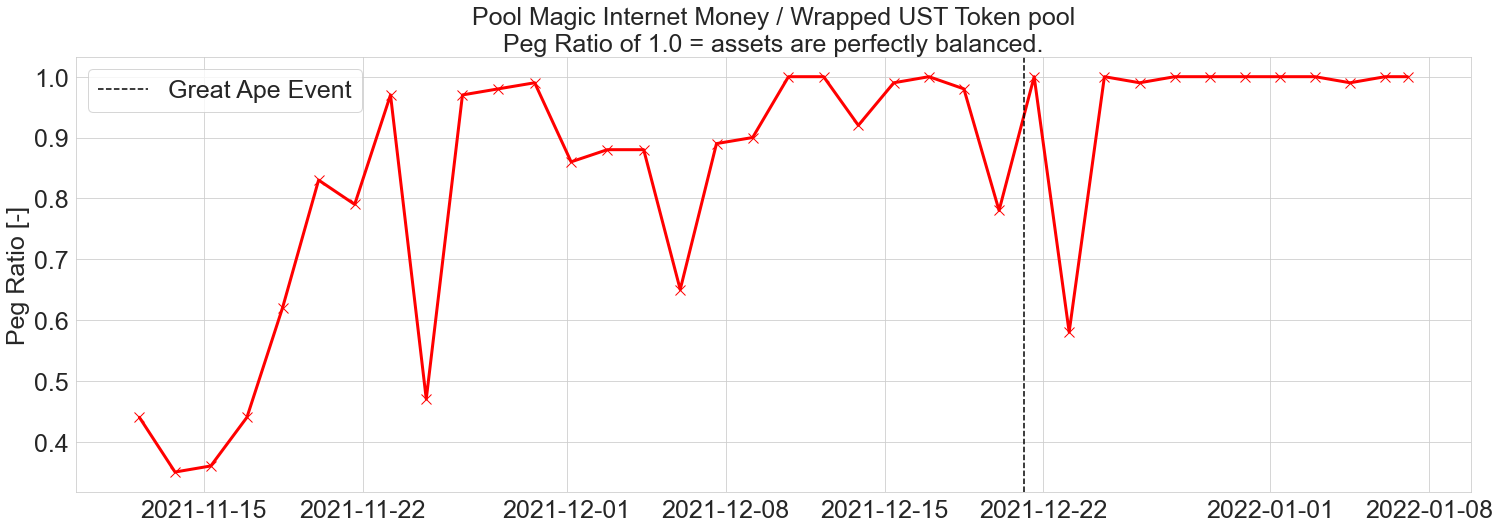

In [41]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))

peg_ratio_explanation = "Peg Ratio of 1.0 = assets are perfectly balanced."
ax.plot(df_plot.timestamp, df_plot.peg_ratio, 'rx-', lw=3, ms=10)

ax.axvline(x=event_timestamp, label="Great Ape Event", color='k', ls='--')

ax.set_xlabel("")
ax.set_ylabel("Peg Ratio [-]", fontsize=25)
ax.set_title(f"Pool {coin_0} / {coin_1} pool\n{peg_ratio_explanation}", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=25);

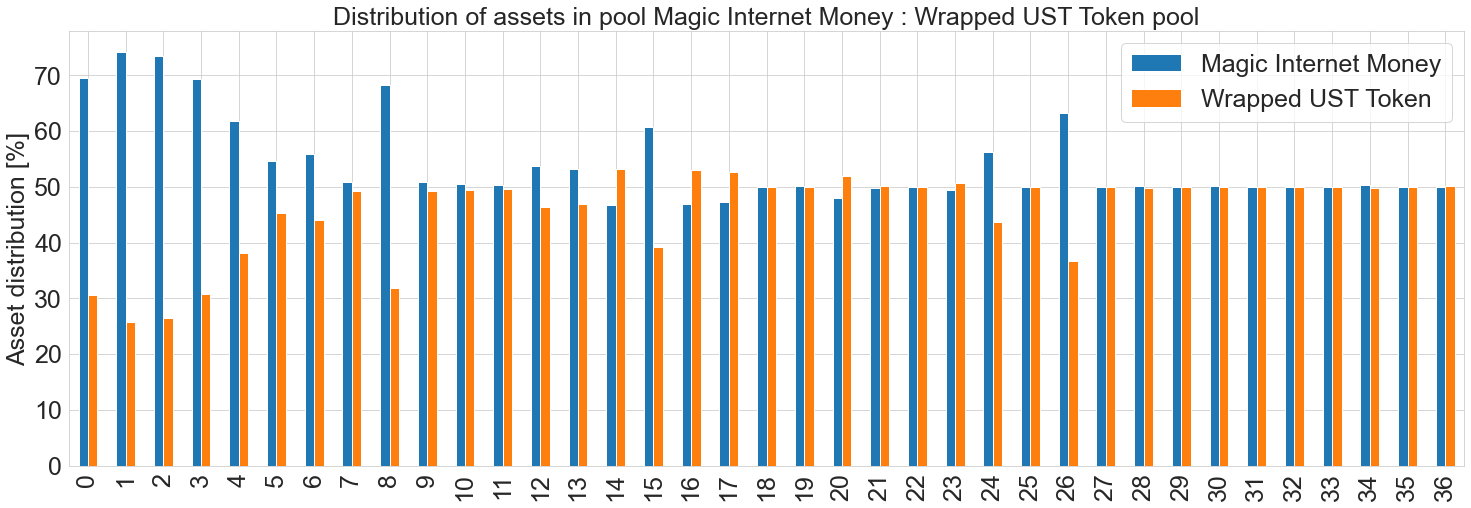

In [39]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))

df_plot[["coin_0_perc", "coin_1_perc"]].plot(ax=ax, kind="bar")

# ax.axvline(x=A, label="Current A", color='k', ls='--')

ax.set_ylabel("Asset distribution [%]", fontsize=25)
ax.set_title(f"Distribution of assets in pool {coin_0} : {coin_1} pool", fontsize=25);
ax.tick_params(axis='both', which='major', labelsize=25);


ax.legend([coin_0, coin_1], fontsize=25);

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))

plot_explanation = "Swap Rate coin 1 to coin 0"
ax.plot(df_plot.timestamp, df_plot.swap_rate_1_to_0, 'rx-', lw=3, ms=10)

ax.axvline(x=bribe_tx, label="Andre's Tweet", color='k', ls='--')

ax.set_ylabel("")
ax.set_ylabel("Swap Rate[-]", fontsize=25)
ax.set_title(f"Pool {coin_0} / {coin_1} pool\n{plot_explanation}", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=25)

disconnect

In [34]:
brownie.network.disconnect()